# Bias correct CESM2 wind speeds to ERA5 using stress

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range

Equation: 

$\tau = \rho C_D U_z |U_z| = \rho C_d U^2 = \rho C_d (u^2 + v^2)$ OR

$ \tau_x = \rho \cdot C_d \cdot u \cdot  \sqrt{u^2 + v^2}$

$ \tau_y = \rho \cdot C_d \cdot v \cdot \sqrt{u^2 + v^2}$

Write out sea ice ($C_{di}$) and ocean ($C_{do}$) drag coefficients and calculate:

$\tau_{ERA5} = \tau_{CESM2}$

$(C_{di ERA5} + C_{do ERA5}) (u_{ERA5}^2 + v_{ERA5}^2) = (C_{di CESM2} + C_{do CESM2}) (u_{CESM2}^2 + v_{CESM2}^2 + bias)$

$\frac{C_{di ERA5} + C_{do ERA5}}{C_{di CESM2} + C_{do CESM2}} (u_{ERA5}^2 + v_{ERA5}^2) = u_{CESM2}^2 + v_{CESM2}^2 + bias$

$bias = \frac{C_{di ERA5} + C_{do ERA5}}{C_{di CESM2} + C_{do CESM2}} (u_{ERA5}^2 + v_{ERA5}^2) - u_{CESM2}^2 - v_{CESM2}^2$

Or alternatively, I could read in wind stress from ERA5 forced experiment and from CESM2 forced experiment: utau_oce, vtau_oce (taum is already written to file)

$C_D$ --- bulk transfer coefficient of momentum


Steps:
- Mean surface air density for ERA5 and CESM2 experiments
- Mean of ERA5 u10 and v10 over the timeseries
- Ensemble mean of CESM2 U and V over the timeseries
- Regrid ERA5 and CESM2 velocities onto the NEMO grid
- Drag coefficients for an experiment with ERA5 and for an experiment with CESM2

OR
- Mean of ERA5 experiment taum
- Mean of CESM2 experiment taum
- Stress bias = difference between these two
- Then, $stress bias = \rho_{air} C_D (u^2 + v^2 + wind bias)$ $\rightarrow$ $wind bias = \frac{stress bias}{\rho_o C_D} - u^2 - v^2$

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250217.nc').squeeze()
land_mask = nemo_mask.tmask.isel(nav_lev=0)

In [3]:
def compare_variable(ds1, ds2, varname, vmin=None, vmax=None, ylim=(None,None), title1='', title2='', title3='Panel 1 - Panel 2', cmap=cmocean.cm.haline):
    kwags = {'vmin':vmin, 'vmax':vmax, 'ylim':ylim, 'cmap':cmap}
    
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    ds1[varname].where(land_mask!=0).plot(ax=ax[0], **kwags)
    ds2[varname].where(land_mask!=0).plot(ax=ax[1], **kwags)
    (ds1[varname] - ds2[varname]).where(land_mask!=0).plot(ax=ax[2], cmap=cmocean.cm.balance, ylim=(50,None), vmin=-3, vmax=3)
    ax[0].set_title(title1); ax[1].set_title(title2); ax[2].set_title(title3);
    
    return fig, ax 

## Let's instead try just scaling the wind with a scalar magnitude.
- air density differences don't change strongly year-to-year (~0.02 on values ranging from 1.25-1.35). Ocean drag changes by ~5e-5 for values between 1.0e-3 to 1.6e-3, so interannual variation is less than the spatial variation within a year. But, could there still be significant drift over time? A bit hard to know what to do about all of that. 
- 

In [ ]:
# instead of looking at the output wind speeds, compare the actual forcing for these analyses (will involve regridding both to the eANT025 grid)

In [ ]:
fig, ax = compare_variable(cesm2era5, cesm2u10, 'windsp', vmin=2, vmax=12, ylim=(50,None), title1='ERA5', title2='CESM2')

In [ ]:
fig, ax = compare_variable(cesm2era5, cesm2_ds, 'windsp', vmin=2, vmax=12, ylim=(50,None), title1='ERA5', title2='CESM2')

In [ ]:
# fraction of wind speeds that are off.
fig, ax = compare_variable((cesm2era5 - cesm2u10)*100/cesm2u10, cesm2era5/cesm2u10, 'windsp', vmin=-20, vmax=20, ylim=(50,None), title1='ERA5', title2='CESM2')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
kwags1={'density':True, 'histtype':'step', 'ax':ax, 'lw':1.5}
kwags2={'density':True, 'ax':ax, 'alpha':0.5}
cesm2era5.windsp.where(land_mask!=0).plot.hist(label='ERA5', **kwags2)
cesm2_ds.windsp.where(land_mask!=0).plot.hist(label='CESM2', **kwags1)
# (cesm2u10.windsp).where(land_mask!=0).plot.hist(label='CESM2 u10', **kwags1)
(cesm2u10.windsp*0.89).where(land_mask!=0).plot.hist(label='CESM2 u10 multiplier', **kwags1)
(cesm2u10.windsp - 0.6).where(land_mask!=0).plot.hist(label='CESM2 u10 shifted', **kwags1)
ax.legend(loc=(1.05, 0.6), frameon=False)

In [ ]:
cesm2_wind = cesm2_ds.windsp.where(land_mask!=0)
cesm2_wind_u10 = cesm2u10.windsp.where(land_mask!=0)
era5_wind  = cesm2era5.windsp.where(land_mask!=0)

wind_rms_u10 = np.sqrt((era5_wind - cesm2_wind_u10)**2)
wind_rms = np.sqrt((era5_wind - cesm2_wind)**2)
wind_rms_multiple = np.sqrt((era5_wind - 0.89*cesm2_wind)**2)
wind_rms_u10_multiple = np.sqrt((era5_wind - 0.89*cesm2_wind_u10)**2)
wind_rms_shifted = np.sqrt((era5_wind - (cesm2_wind - 0.6))**2)
wind_rms_u10_shifted = np.sqrt((era5_wind - (cesm2_wind_u10 - 0.6))**2)
# wind_rms_spatial  = np.sqrt((era5_wind - spatial_diff*cesm2_wind)**2)

minimize rms of spacial field --- check whether a constant multiplier would work or a spatially varying one. 
Plus whether it should be a multiplier versus and offset.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
kwags1={'density':True, 'histtype':'step', 'lw':1.5, 'ax':ax, 'bins':30}
wind_rms.plot.hist(bins=30, ax=ax, color='blue', density=True, label='Original UBOT difference')
wind_rms_u10.plot.hist(color='magenta', label='Original U10 difference', **kwags1)

wind_rms_multiple.plot.hist(label='CESM2 UBOT multiplied by consant', color='orange', **kwags1)
wind_rms_u10_multiple.plot.hist(color='purple', label='CESM2 U10 multiplied by constant', **kwags1)

wind_rms_shifted.plot.hist(label='CESM2 UBOT constant shift', color='cyan', **kwags1)
wind_rms_u10_shifted.plot.hist(label='CESM2 U10 constant shift', color='red', **kwags1)
# wind_rms_multiple.plot.hist(label='CESM2 u10 spatially varying multiplier', color='magenta', **kwags1)

plt.axvline(wind_rms.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_u10.mean(), color='magenta', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_multiple.mean(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_u10_multiple.mean(), color='purple', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_shifted.mean(), color='cyan', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_u10_shifted.mean(), color='red', linestyle='dashed', linewidth=1)
ax.legend(loc=(1.05, 0.6), frameon=False)
ax.set_title('')
ax.set_xlabel('Wind speed RMSE')

## Repeat analysis but with original input wind fields

In [ ]:
# year = 1979
month= 1
# cesm2_u = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_UBOT_y{year}.nc').mean(dim='time')
# cesm2_v = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_VBOT_y{year}.nc').mean(dim='time')
# calculate the mean over all januaries

end_year=2000
cesm2_u10 = xr.open_mfdataset([f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_U10x_y{year}.nc' for year in range(1979,end_year)])
# cesm2_u10 = cesm2_u10.isel(time=cesm2_u10.time.dt.month==month).mean(dim='time')
cesm2_u10 = cesm2_u10.mean(dim='time')
cesm2_v10 = xr.open_mfdataset([f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_U10y_y{year}.nc' for year in range(1979,end_year)])
# cesm2_v10 = cesm2_v10.isel(time=cesm2_v10.time.dt.month==month).mean(dim='time')
cesm2_v10 = cesm2_v10.mean(dim='time')
era5_u    = xr.open_mfdataset([f'{base_dir}ERA5-forcing/daily/files/processed/u10_time_y{year}.nc' for year in range(1979,end_year)])
# era5_u    = era5_u.isel(time=era5_u.time.dt.month==month).mean(dim='time')
era5_u    = era5_u.mean(dim='time')
era5_v    = xr.open_mfdataset([f'{base_dir}ERA5-forcing/daily/files/processed/v10_time_y{year}.nc' for year in range(1979,end_year)])
# era5_v    = era5_v.isel(time=era5_v.time.dt.month==month).mean(dim='time')
era5_v    = era5_v.mean(dim='time')

In [9]:
from nemo_python_git.interpolation import interp_latlon_cf

In [10]:
def regrid_to_NEMO(ds, varname, nemo_coord=f'{base_dir}bathymetry/domain_cfg-20240305.nc'):
    
    nemo_coord_file = xr.open_dataset(nemo_coord).squeeze()
    name_remapping  = {'longitude':'lon', 'latitude':'lat'}

    try:
        source_var = ds.rename(name_remapping).sortby('lat').sel(lat=slice(-90, -50))
    except:
        source_var = ds.sortby('lat').sel(lat=slice(-90, -50))
        
    if source_var.lon.max() > 180: # Convert longitudes from 0-360 to -180 to 180 
        source_var['lon'] = fix_lon_range(source_var.lon)
    source_var = source_var.sortby('lon')[varname]
    source_var = xr.where(source_var==0, np.nan, source_var)

    # Now wrap up into a new dataset and interpolate
    ds_source = xr.Dataset({'lon':source_var['lon'], 'lat':source_var['lat'], varname:source_var})
    print('Interpolating')
    interp_src = interp_latlon_cf(ds_source, nemo_coord_file, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
    
    return interp_src

In [ ]:
cesm2_u10_nemo = regrid_to_NEMO(cesm2_u10, 'U10x')
cesm2_v10_nemo = regrid_to_NEMO(cesm2_v10, 'U10y')
cesm2_u10_nemo = cesm2_u10_nemo.rename({'U10x':'u10'})
cesm2_v10_nemo = cesm2_v10_nemo.rename({'U10y':'v10'})
era5_u10_nemo = regrid_to_NEMO(era5_u, 'u10')
era5_v10_nemo = regrid_to_NEMO(era5_v, 'v10')

In [ ]:
domcfg  = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20240305.nc').isel(x=slice(0,None,5), y=slice(0,None,5))

In [ ]:
from nemo_python_git.utils import rotate_vector

#era5_v10_nemo.v10.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5))

cesm2_ux, cesm2_uy = rotate_vector(cesm2_u10_nemo.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).u10,
                                   cesm2_v10_nemo.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).v10, 
                                   domcfg=domcfg, reverse=True)

In [ ]:
cesm2_u10_nemo.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).u10.plot(figsize=(10,4))
cesm2_ux.plot(figsize=(10,4))
(cesm2_u10_nemo.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).u10 - cesm2_ux).plot(figsize=(10,4))

In [ ]:
cesm2_speed = np.sqrt(cesm2_u10_nemo.u10**2 + cesm2_v10_nemo.v10**2).where(land_mask!=0).rename('wind_speed').to_dataset()
era5_speed  = np.sqrt(era5_u10_nemo.u10**2 + era5_v10_nemo.v10**2).where(land_mask!=0).rename('wind_speed').to_dataset()

In [ ]:
wind_rms = np.sqrt((era5_speed - cesm2_speed)**2)['wind_speed']
wind_rms_multiple = np.sqrt((era5_speed - 0.8*cesm2_speed)**2)['wind_speed']
wind_rms_shifted = np.sqrt((era5_speed - (cesm2_speed - 0.6))**2)['wind_speed']
# wind_rms_spatial  = np.sqrt((era5_wind - spatial_diff*cesm2_wind)**2)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
kwags1={'density':True, 'histtype':'step', 'lw':1.5, 'ax':ax, 'bins':30}
wind_rms.plot.hist(bins=30, ax=ax, color='blue', density=True, label='Original difference')
wind_rms_multiple.plot.hist(label='CESM2 multiplied by consant', color='orange', **kwags1)
wind_rms_shifted.plot.hist(label='CESM2 constant shift', color='cyan', **kwags1)

# plt.axvline(wind_rms.mean(), color='blue', linestyle='dashed', linewidth=1)
# plt.axvline(wind_rms_multiple.mean(), color='orange', linestyle='dashed', linewidth=1)
# plt.axvline(wind_rms_shifted.mean(), color='cyan', linestyle='dashed', linewidth=1)
ax.legend(loc=(1.05, 0.6), frameon=False)
ax.set_title('')
ax.set_xlabel('Wind speed RMSE')

In [ ]:
#  create figure with wind speed difference in each month:
fig, ax = plt.subplots(4,3, figsize=(20,16))

varname='wind_speed'
for m, axis in enumerate(ax.ravel()):

    month=m+1
    print('Month', month)
    cesm2_u10 = xr.open_mfdataset([f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_U10x_y{year}.nc' for year in range(1979,2024)])
    cesm2_u10 = cesm2_u10.isel(time=cesm2_u10.time.dt.month==month).mean(dim='time')
    cesm2_v10 = xr.open_mfdataset([f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_U10y_y{year}.nc' for year in range(1979,2024)])
    cesm2_v10 = cesm2_v10.isel(time=cesm2_v10.time.dt.month==month).mean(dim='time')
    era5_u    = xr.open_mfdataset([f'{base_dir}ERA5-forcing/daily/files/processed/u10_time_y{year}.nc' for year in range(1979,2024)])
    era5_u    = era5_u.isel(time=era5_u.time.dt.month==month).mean(dim='time')
    era5_v    = xr.open_mfdataset([f'{base_dir}ERA5-forcing/daily/files/processed/v10_time_y{year}.nc' for year in range(1979,2024)])
    era5_v    = era5_v.isel(time=era5_v.time.dt.month==month).mean(dim='time')

    cesm2_u10_nemo = regrid_to_NEMO(cesm2_u10, 'U10x')
    cesm2_v10_nemo = regrid_to_NEMO(cesm2_v10, 'U10y')
    cesm2_u10_nemo = cesm2_u10_nemo.rename({'U10x':'u10'})
    cesm2_v10_nemo = cesm2_v10_nemo.rename({'U10y':'v10'})

    era5_u10_nemo = regrid_to_NEMO(era5_u, 'u10')
    era5_v10_nemo = regrid_to_NEMO(era5_v, 'v10')
    cesm2_speed = np.sqrt(cesm2_u10_nemo.u10**2 + cesm2_v10_nemo.v10**2).where(land_mask!=0).rename('wind_speed').to_dataset()
    era5_speed  = np.sqrt(era5_u10_nemo.u10**2 + era5_v10_nemo.v10**2).where(land_mask!=0).rename('wind_speed').to_dataset()
    
    (era5_speed[varname] - cesm2_speed[varname]).where(land_mask!=0).plot(ax=axis, cmap=cmocean.cm.balance, ylim=(50,None), vmin=-3, vmax=3)
    axis.set_title(f'Month: {month}')


fig.savefig(f'{base_dir}figures/wind-difference-monthly-climatology_1979-2024.jpg')

In [ ]:
# consider only correcting the higher wind speed north of the peninsula

In [ ]:
fig, ax = compare_variable(era5_u10_nemo, cesm2_u10_nemo, 'u10', vmin=-9, vmax=9, ylim=(50,None), title1='ERA5', title2='CESM2', cmap=cmocean.cm.balance)

In [ ]:
fig, ax = compare_variable(era5_v10_nemo, cesm2_v10_nemo, 'v10', vmin=-9, vmax=9, ylim=(50,None), title1='ERA5', title2='CESM2', cmap=cmocean.cm.balance)

In [ ]:
fig, ax = compare_variable(era5_speed, cesm2_speed, 'wind_speed', vmin=2, vmax=12, ylim=(50,None), title1='ERA5', title2='CESM2')

In [ ]:
fig, ax = compare_variable(era5_speed, cesm2_speed*0.8, 'wind_speed', vmin=2, vmax=12, ylim=(50,None), title1='ERA5', title2='CESM2')

The wind speeds that the ocean sees based on the SBC output are different from the raw files (less magnitude difference). What causes this difference? Is the output wind speed a combination of wind speed and drag?

Is the low value just the sea ice imprint? Try the same but monthly.

In [ ]:
era5_uwind = era5_u.u10.sortby('longitude').sortby('latitude').sel(latitude=slice(-90,-50))
era5_vwind = era5_v.v10.sortby('longitude').sortby('latitude').sel(latitude=slice(-90,-50))

In [ ]:
(era5_vwind.differentiate('longitude') - era5_uwind.differentiate('latitude')).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance, figsize=(10,4))

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,4))
kwags = {'vmin':-0.8, 'vmax':0.8, 'cmap':cmocean.cm.balance, 'ylim':(30,None)}
era5_curl  = era5_v10_nemo.v10.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).differentiate('x') - \
             era5_u10_nemo.u10.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).differentiate('y') 
cesm2_curl = cesm2_v10_nemo.v10.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).differentiate('x') - \
             cesm2_u10_nemo.u10.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).differentiate('y')

era5_curl.plot(ax=ax[0], **kwags)
cesm2_curl.plot(ax=ax[1], **kwags)
(era5_curl - cesm2_curl).plot(ax=ax[2], **kwags)
ax[0].set_title('Wind curl ERA5'); ax[1].set_title('Wind curl CESM2'); ax[2].set_title('ERA5-CESM2')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,4))
kwags = {'vmin':-0.8, 'vmax':0.8, 'cmap':cmocean.cm.balance, 'ylim':(30,None)}
era5_div  = era5_v10_nemo.v10.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).differentiate('y') + \
             era5_u10_nemo.u10.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).differentiate('x') 
cesm2_div = cesm2_v10_nemo.v10.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).differentiate('y') + \
             cesm2_u10_nemo.u10.where(land_mask!=0).isel(x=slice(0,None,5), y=slice(0,None,5)).differentiate('x')

era5_div.plot(ax=ax[0], **kwags)
cesm2_div.plot(ax=ax[1], **kwags)
(era5_div - cesm2_div).plot(ax=ax[2], **kwags)
ax[0].set_title('Wind divergence ERA5'); ax[1].set_title('Wind divergence CESM2'); ax[2].set_title('ERA5-CESM2')

In [ ]:
(era5_u10_nemo.u10.where(land_mask!=0).differentiate('x') + \
 era5_v10_nemo.v10.where(land_mask!=0).differentiate('y')).plot(vmin=-0.1, vmax=0.1, cmap=cmocean.cm.balance, figsize=(10,4), ylim=(150,None))

In [ ]:
(era5_vwind.differentiate('latitude') + era5_uwind.differentiate('longitude')).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance, figsize=(10,4))

In [ ]:
(cesm2_u10_nemo.u10.where(land_mask!=0).differentiate('x') + \
 cesm2_v10_nemo.v10.where(land_mask!=0).differentiate('y')).plot(vmin=-0.1, vmax=0.1, cmap=cmocean.cm.balance, figsize=(10,4), ylim=(150,None))

### Calculate multiplier

In [4]:
from nemo_python_git.constants import cesm2_ensemble_members

In [5]:
start_year=1979
end_year=2023
varx = 'U10x'; vary='U10y'
ens_strs = cesm2_ensemble_members
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/processed/'
era5_dir  = f'{base_dir}ERA5-forcing/daily/files/processed/'

# # Load all ensemble files for specified dates and ensemble members into xarray datasets
# cesm2_ufiles = []; cesm2_vfiles = [];
# for e, ens in enumerate(ens_strs):
#     print(ens)
#     cesm2_u = xr.open_mfdataset([f'{cesm2_dir}CESM2-LE2_ens{ens}_{varx}_y{year}.nc' for year in range(start_year,end_year+1)])
#     cesm2_v = xr.open_mfdataset([f'{cesm2_dir}CESM2-LE2_ens{ens}_{vary}_y{year}.nc' for year in range(start_year,end_year+1)])

#     if e==0:
#         cesm2_u10 = cesm2_u.copy().expand_dims(dim="ens")
#         cesm2_v10 = cesm2_v.copy().expand_dims(dim="ens")
#     else:
#         cesm2_u10 = xr.concat([cesm2_u10, cesm2_u], dim='ens')
#         cesm2_v10 = xr.concat([cesm2_v10, cesm2_v], dim='ens')

# cesm2_u10 = cesm2_u10.assign({'ens':ens_strs})
# cesm2_v10 = cesm2_v10.assign({'ens':ens_strs})
name_remapping = {'longitude':'lon', 'latitude':'lat'}
era5_u = xr.open_mfdataset([f'{era5_dir}u10_time_y{year}.nc' for year in range(start_year,end_year+1)]).rename(name_remapping)
era5_v = xr.open_mfdataset([f'{era5_dir}v10_time_y{year}.nc' for year in range(start_year,end_year+1)]).rename(name_remapping)

In [9]:
cesm2_u10.sortby('lat').sel(lat=slice(-90,-50)).mean(dim='ens').mean(dim='time').to_netcdf(f'{cesm2_dir}CESM2-LE2_u10_ensemble_mean.nc')

In [10]:
cesm2_v10.sortby('lat').sel(lat=slice(-90,-50)).mean(dim='ens').mean(dim='time').to_netcdf(f'{cesm2_dir}CESM2-LE2_v10_ensemble_mean.nc')

In [6]:
def process_atm_input(ds, var):

    #ds = ds.sortby('lat').sel(lat=slice(-90,-50)).mean(dim='time')

    ds_nemo = regrid_to_NEMO(ds, var)
    ds_nemo = ds_nemo.where(land_mask!=0)
    
    return ds_nemo

In [7]:
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/processed/'
ds_u10 = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_u10_ensemble_mean.nc')
ds_v10 = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_v10_ensemble_mean.nc')

In [11]:
# cesm2_u10_nemo = process_atm_input(cesm2_u10.mean(dim='ens'), 'U10x')
# cesm2_v10_nemo = process_atm_input(cesm2_v10.mean(dim='ens'), 'U10y')

cesm2_u10_nemo = process_atm_input(ds_u10, 'U10x')
cesm2_v10_nemo = process_atm_input(ds_v10, 'U10y')

Interpolating
Interpolating


In [12]:
era5_u10_nemo = process_atm_input(era5_u.sortby('lat').sel(lat=slice(-90,-50)).mean(dim='time'), 'u10')
era5_v10_nemo = process_atm_input(era5_v.sortby('lat').sel(lat=slice(-90,-50)).mean(dim='time'), 'v10')

Interpolating
Interpolating


In [15]:
cesm2_speed = np.sqrt(cesm2_u10_nemo.U10x**2 + cesm2_v10_nemo.U10y**2).rename('wind_speed').to_dataset()
era5_speed  = np.sqrt(era5_u10_nemo.u10**2 + era5_v10_nemo.v10**2).rename('wind_speed').to_dataset()

In [18]:
print((era5_speed.wind_speed/cesm2_speed.wind_speed).median())
# print((era5_speed.wind_speed/cesm2_speed.wind_speed).mean())

<xarray.DataArray 'wind_speed' ()> Size: 8B
array(0.77138604)
Coordinates:
    nav_lev       float32 4B 0.4921
    time_counter  float32 4B 0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '')

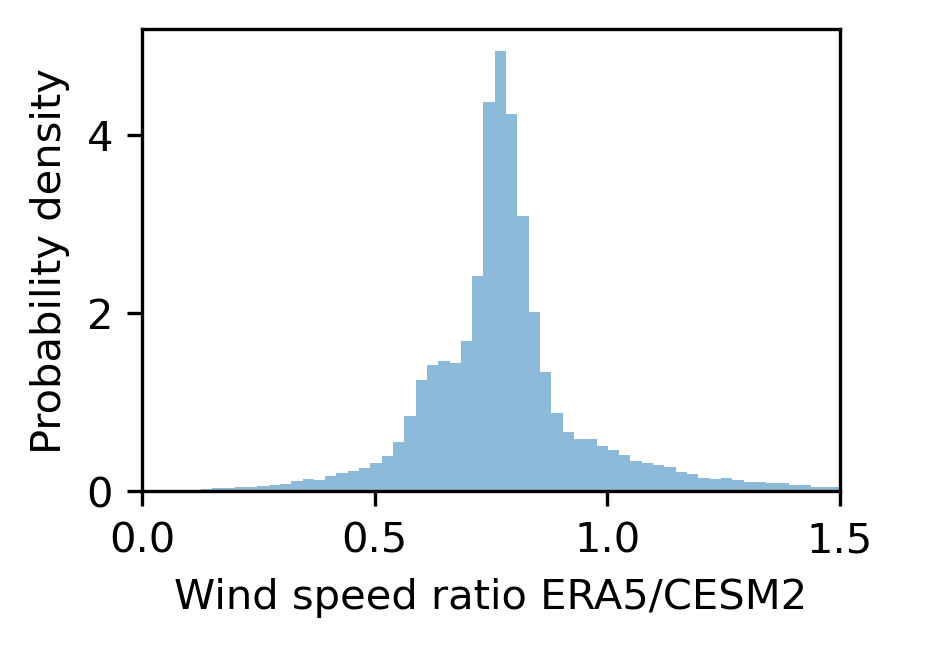

In [31]:
fig, ax = plt.subplots(1,1, figsize=(3,2), dpi=300)
kwags2={'density':True, 'ax':ax, 'alpha':0.5, 'bins':2000}
(era5_speed.wind_speed/cesm2_speed.wind_speed).plot.hist(**kwags2)
ax.legend(loc=(1.05, 0.6), frameon=False)
ax.set_xlim(0,1.5)
ax.set_xlabel('Wind speed ratio ERA5/CESM2')
ax.set_ylabel('Probability density')
ax.set_title('')

Text(0.5, 1.0, '')

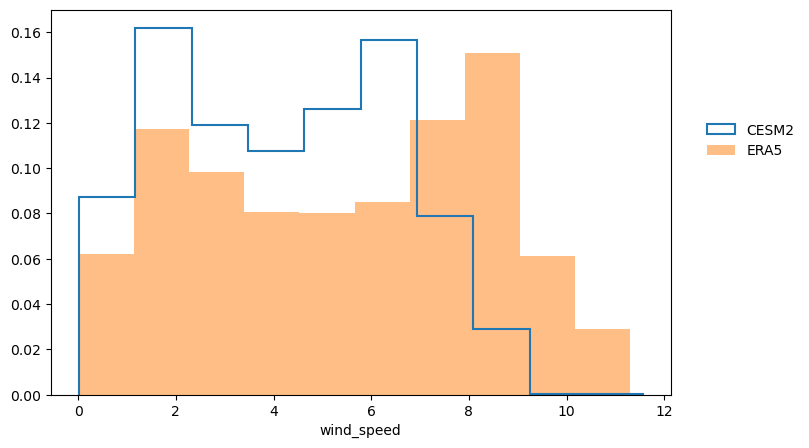

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
kwags1={'density':True, 'histtype':'step', 'ax':ax, 'lw':1.5}
kwags2={'density':True, 'ax':ax, 'alpha':0.5}
era5_speed.wind_speed.plot.hist(label='CESM2', **kwags1)
cesm2_speed.wind_speed.plot.hist(label='ERA5', **kwags2)
ax.legend(loc=(1.05, 0.6), frameon=False)
# ax.set_xlim(0,1.5)
ax.set_title('')

In [ ]:
year=1990
cesm2_u = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_ens1011.001_U10x_y{year}.nc')
cesm2_v = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_ens1011.001_U10y_y{year}.nc')
u_bias_corrected = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/bias-corrected/CESM2-LE2_ens1011.001_U10x_bias_corr_y{year}.nc')
v_bias_corrected = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/bias-corrected/CESM2-LE2_ens1011.001_U10y_bias_corr_y{year}.nc')

```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 272829 |ssh| max   20.01     at i j    707 221     MPI rank 160
 kt 272829 |U|   max   1.118     at i j k  308 451   1 MPI rank 741
 kt 272829 Sal   min  1.3292E-03 at i j k  707 221   4 MPI rank 160
 kt 272829 Sal   max   34.93     at i j k  178 452 110 MPI rank 736
```

In [ ]:
ds_bathy = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc')

In [ ]:
ds_bathy.isf_draft.plot(xlim=(690, 710), ylim=(200, 250), vmin=0, vmax=1000)

In [ ]:
ds_bathy.imask.plot(xlim=(680, 720), ylim=(200, 280))

In [ ]:
dsT = xr.open_dataset(f'{base_dir}output/CESM2_hist9/files0/eANT025.L121_1m_19900101_19901231_grid_T.nc')

In [ ]:
dsT.so.isel(time_counter=0, x_grid_T=706, y_grid_T=slice(200,280)).plot(ylim=(1500, 0), figsize=(10,5))

In [ ]:
dsT.so.isel(time_counter=0, y_grid_T=220).plot(ylim=(1500, 0), xlim=(680,730), figsize=(10,5))

In [ ]:
dsT.so.isel(time_counter=0, y_grid_T=219).plot(ylim=(1500, 0), xlim=(680,730), figsize=(10,5))

In [ ]:
dsT.so.isel(time_counter=0, deptht=0).plot(figsize=(10,8), xlim=(700, 710), ylim=(210,225), vmin=0, vmax=35)

In [ ]:
dsT.so.isel(time_counter=0, deptht=0).plot(figsize=(10,8), xlim=(600, 780), ylim=(160,260), vmin=0, vmax=35)

In [ ]:
dsT.so.isel(time_counter=0, deptht=0).plot(figsize=(6,4), xlim=(690, 720), ylim=(200,240), vmin=0, vmax=35)
dsT.so.isel(time_counter=-1, deptht=0).plot(figsize=(6,4), xlim=(690, 720), ylim=(200,240), vmin=0, vmax=35)

so somehow this individual cell loses salinity rapidly in that month. Should it even be open? I'm somewhat tempted to close it because it seems weird to have just one "ice chimney"

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
cesm2_u.isel(time=slice(0,365)).mean(dim='time').U10x.sortby('lon').plot(ax=ax[0], ylim=(-90,-50), vmin=-10, vmax=10, cmap=cmocean.cm.balance)
u_bias_corrected.mean(dim='time').U10x.sortby('lon').plot(ax=ax[1], ylim=(-90,-50), vmin=-10, vmax=10, cmap=cmocean.cm.balance)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
cesm2_v.isel(time=slice(0,365)).mean(dim='time').U10y.sortby('lon').plot(ax=ax[0], ylim=(-90,-50), vmin=-10, vmax=10, cmap=cmocean.cm.balance)
v_bias_corrected.mean(dim='time').U10y.sortby('lon').plot(ax=ax[1], ylim=(-90,-50), vmin=-10, vmax=10, cmap=cmocean.cm.balance)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
cesm2_v.isel(time=slice(0,365)).mean(dim='time').U10y.sortby('lon').plot(ax=ax[0], ylim=(-90,-50), vmin=-10, vmax=10, cmap=cmocean.cm.balance)
(cesm2_v.isel(time=slice(0,365)).mean(dim='time').U10y.sortby('lon')*0.8 - v_bias_corrected.mean(dim='time').U10y.sortby('lon')).plot(ax=ax[1], ylim=(-90,-50), vmin=-1, vmax=1, cmap=cmocean.cm.balance)